In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Data are from ABI 3730 DNA analyzer, which measures fluorescence over time for 5 different fluorophores 
#from 96 different capillaries simultaneously. To load this data into python, I took output from the sequencer
#in the format .fsa and converted it into .txt files using the program datafileconverter (http://dotwhat.net/file/extension/fsa/8752)
#import data from different wells into a data structure

data = {}
files = !ls Experiment_files/*.txt
for file1 in files:
    lines = []
    values = []
    wellname = file1[len(file1) - 11:len(file1) - 8]
    for line in open(file1).readlines():
        values = line.split('\t')
        if values[0] != 'DATA':
            continue
        lines.append(line)
    welldata = {}
    values = []
    for line in lines:
        value = line.split()[5:]
        value = np.array([int(x) for x in value])
        values.append( value )
    
    welldata["FAM"] = values[0]
    welldata["VIC"] = values[1]
    welldata["NED"] = values[2]
    welldata["PET"] = values[3]
    welldata["LIZ"] = values[8]
    data[wellname] = welldata


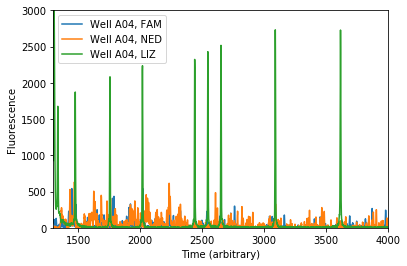

In [3]:
#In this experiment, I ran experimental denatured DNA labeled with either NED or FAM alongside a spiked-in ladder
#labeled with LIZ (https://www.thermofisher.com/order/catalog/product/4322682)

#Plot data from a single well for all three fluorophores
start = 200
end = start + 7000
window = np.arange(start,end)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(window,data['A04']['FAM'][window],label='Well A04, FAM')
ax.plot(window,data['A04']['NED'][window],label='Well A04, NED')
ax.plot(window,data['A04']['LIZ'][window],label='Well A04, LIZ')
ax.set_xlim(left = 1300, right = 4000)
ax.set_ylim(top = 3000, bottom = 0)

ax.legend()
ax.set_ylabel('Fluorescence')
ax.set_xlabel('Time (arbitrary)')
fig.savefig( 'Well_A04_fluors.png' )

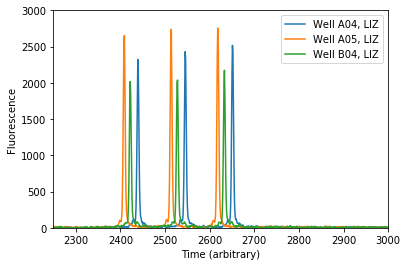

In [4]:
#Data from separate wells are not directly comparable because the DNA run through the separate capillaries in the
#96 well array at slightly different rates. Within each well, DNA flows through the capillary at a speed determined
#by the size of the molecule.

#Plot data from separate wells to demonstrate slight differences in run time of LIZ standard
start = 200
end = start + 7000
window = np.arange(start,end)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(window,data['A04']['LIZ'][window],label='Well A04, LIZ')
ax.plot(window,data['A05']['LIZ'][window],label='Well A05, LIZ')
ax.plot(window,data['B04']['LIZ'][window],label='Well B04, LIZ')
ax.set_xlim(left = 2250, right = 3000)
ax.set_ylim(top = 3000, bottom = 0)

ax.legend()
ax.set_ylabel('Fluorescence')
ax.set_xlabel('Time (arbitrary)')
fig.savefig( 'Wells_A046_LIZ.png' )

In [5]:
#The data from each well can be normalized to the interal size standard to convert the data to fluorescence vs
#DNA size, removing any heterogeneity in run time between capillaries. To do this, I first wrote an algorithm
#to define the locations of peaks within each well corresponding to DNA molecules

#The algorithm scans through fluorescence data for each well for the 3 separate fluorophores in windows of size
#determined by window_half. The algorithm fits a polynomial of degree specific by poly to the fluorescence data 
#in each window and differentiates this polynomial to find positions with derivate of 0 indicative of a maxima or minima
#The algorithm will call a position with a derivative of 0 a peak if:
#1. the position of the root is at the center of the present window to maximize accuracy of the fit polynomial
#and minimize edge effects
#2. the peak has a positive slope greater than the slope_thresh before and after the maxima position at position
#of peak_half
#3. the peak is not within distance of peak_half from a previously called peak
#
def peak_call(data,window_half,peak_half,poly,slope_thresh):
    global peaks
    peaks = {}
    for well in data:
        welldata = {}
        for fluor in ['NED','FAM','LIZ']:
            d = []
            d = data[well][fluor]
            place = window_half + 1
            maxima_count = 0
            maxima_info = {}
            while place < (len(d)-window_half):
                window = []
                window = np.arange(place - window_half,place + window_half)
                func = []
                func = np.poly1d(np.polyfit(window,d[window],poly))
                first_deriv = []
                first_deriv = func.deriv()
                first_deriv_roots = []
                first_deriv_roots = first_deriv.r
                for index, root in enumerate(first_deriv_roots): #loop through all roots at this position
                    if root > place - 1 and root < place + 1: #is the root within 1 of the place you centered the fitting window on?
                        if first_deriv(root - peak_half) > slope_thresh and first_deriv(root + peak_half) < -slope_thresh: #is the root a maxima that passes the slope threshold?
                            unique = 0
                            for values in maxima_info.values():
                                if root < values[0] + peak_half and root > value[0] - peak_half: #is current root within half a peak of a previously called root?
                                    unique = unique + 1
                            if unique == 0:
                                maxima_count = maxima_count + 1
                                maxima_info[maxima_count] = [root, place]

                place = place + 1
            welldata[fluor] = pd.DataFrame(maxima_info,index = ['position','nearest_data'])
        peaks[well] = welldata
    


In [6]:
peak_call(data,8,2,4,40)

In [7]:
#Output of peak_call
peaks['A04']['LIZ']

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
position,1096.622522,1180.698326,1212.566904,1225.884191,1232.396969,1245.222589,1256.421424,1267.339262,1305.405112,1335.044648,...,2651.098959,3088.938485,3614.832124,4201.113781,4632.288624,4747.538036,5325.044116,5862.072384,6303.762738,6396.49688
nearest_data,1096.000000,1180.000000,1212.000000,1225.000000,1232.000000,1245.000000,1257.000000,1267.000000,1305.000000,1335.000000,...,2651.000000,3088.000000,3614.000000,4201.000000,4632.000000,4747.000000,5325.000000,5862.000000,6303.000000,6396.00000


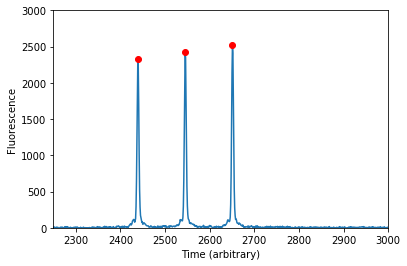

In [8]:
#plot the position of determined peak maxima for one well
start = 1000
end = start + 6000
x_vector = np.arange(start,end)
std_data = peaks['A04']['LIZ']
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x_vector,data['A04']['LIZ'][x_vector])
for col in std_data.columns:
    ax.plot(std_data.loc['nearest_data',col],data['A04']['LIZ'][int(std_data.loc['nearest_data',col])], color='r',marker = 'o')

ax.set_xlim(left = 2250, right = 3000)
ax.set_ylim(top = 3000, bottom = 0)
ax.set_ylabel('Fluorescence')
ax.set_xlabel('Time (arbitrary)')
fig.savefig( 'Wells_A046_LIZ_peakpos.png' )



In [9]:
#size_norm is a function to normalize the data in each well to the identified peaks in the LIZ channel
#given their known sizes is nucleotides. Takes as input, the peaks output of peak_call and poly which determines
#the degree of the polynomial fit to the size vs time data for the liz peaks
def size_norm(peaks,data,poly):
    global data_size_norm
    data_size_norm = {}
    poly = 2
    sizes = [50,75,100,139,150,160,200,250,300,340,350,400,450,490,500]
    for well in data:
        if len(peaks[well]['LIZ'].iloc[0,:]) > 15:
            std_data = []
            std_data = peaks[well]['LIZ'].iloc[0,-15:]
            norm_func = np.poly1d(np.polyfit(std_data,sizes,poly))
            x = np.arange(0,len(data[well]['LIZ']))
            data_size_norm[well] = norm_func(x)

In [10]:
size_norm(peaks,data,2)

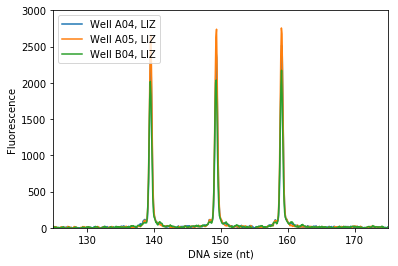

In [11]:
#Plot normalized data from separate wells to demonstrate effects of size normalization 
start = 200
end = start + 7000
window = np.arange(start,end)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(data_size_norm['A04'][window],data['A04']['LIZ'][window],label='Well A04, LIZ')
ax.plot(data_size_norm['A05'][window],data['A05']['LIZ'][window],label='Well A05, LIZ')
ax.plot(data_size_norm['B04'][window],data['B04']['LIZ'][window],label='Well B04, LIZ')
ax.set_xlim(left = 125, right = 175)
ax.set_ylim(top = 3000, bottom = 0)

ax.legend()
ax.set_ylabel('Fluorescence')
ax.set_xlabel('DNA size (nt)')
fig.savefig( 'Wells_A046_LIZ_normalized.png' )

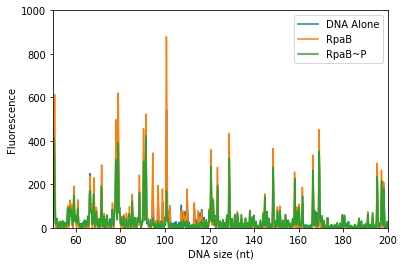

In [12]:
#The data from this experiment are from a DNAse I footprinting experiment. A DNA probe consisting of the promoter
#sequence of the rpod5 gene from Synechococcus elongatus was amplified and labelled on one strand with a FAM primer
#and on the other strand using a NED primer. The probe was incubated in vitro with purified RpaA, RpaB, or phosphorylated
#forms of the protein. After incubation, the DNA was digested with DNAse I prior to denaturation and running on the
#ABI sequencer. If a protein bound to the probe, it inhibits DNAse I digestion of the DNA, leading to diminished intensity
#of DNA peaks corresponding to that region of the probe.

#Now that the data are normalized, we can plot the peaks of the FAM labelled DNA strand incubated with different proteins
#and combinations. 
start = 200
end = start + 7000
window = np.arange(start,end)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(data_size_norm['A04'][window],data['A04']['FAM'][window],label='DNA Alone')
#ax.plot(data_size_norm['B04'][window],data['B04']['FAM'][window],label='RpaA')
#ax.plot(data_size_norm['C04'][window],data['C04']['FAM'][window],label='RpaA~P')
ax.plot(data_size_norm['D04'][window],data['D04']['FAM'][window],label='RpaB')
ax.plot(data_size_norm['E04'][window],data['E04']['FAM'][window],label='RpaB~P')
#ax.plot(data_size_norm['F04'][window],data['F04']['FAM'][window],label='RpaA,B')
#ax.plot(data_size_norm['G04'][window],data['G04']['FAM'][window],label='RpaA,B~P')
#ax.plot(data_size_norm['H04'][window],data['H04']['FAM'][window],label='RpaB,A~P')
#ax.plot(data_size_norm['A05'][window],data['A05']['FAM'][window],label='RpaA~P,B~P')
#ax.plot(data_size_norm['E01'][window],data['E01']['FAM'][window],label='A',alpha=1)
#ax.plot(data_size_norm['F01'][window],data['F01']['FAM'][window],label='T',alpha=1)
#ax.plot(data_size_norm['G01'][window],data['G01']['FAM'][window],label='G',alpha=1)
#ax.plot(data_size_norm['H01'][window],data['H01']['FAM'][window],label='C',alpha=1)

ax.set_xlim(left = 50, right = 200)
ax.set_ylim(top = 1000, bottom = 0)
ax.legend()
ax.set_ylabel('Fluorescence')
ax.set_xlabel('DNA size (nt)')
fig.savefig( 'RpoD5_RpaB_RpaBP.png' )

#This plot reveals a region between ~90 nt and 120 nt where DNA peaks on the FAM strand decrease in abundance
#when phosphorylated RpaB (RpaB~P) is added, relative to experiments with DNA alone or unphosphorylated RpaB
#suggesting that phosphorylated RpaB binds to this region of the DNA


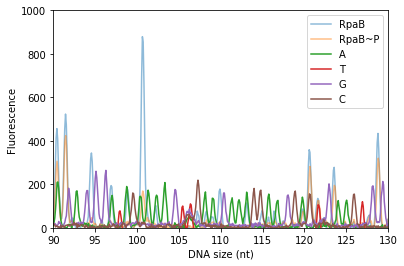

In [13]:
#To determine the underlying sequence of the region bound by RpaB~P, we can compare the sizes of the DNA within the
#footprint to a ladder consisting of traditional Sanger Sequencing reactions conducted with the same primer
#for bases A, T, G, and C
start = 200
end = start + 7000
window = np.arange(start,end)
fig = plt.figure()
ax = plt.subplot(111)
#ax.plot(data_size_norm['A04'][window],data['A04']['FAM'][window],label='DNA Alone')
#ax.plot(data_size_norm['B04'][window],data['B04']['FAM'][window],label='RpaA')
#ax.plot(data_size_norm['C04'][window],data['C04']['FAM'][window],label='RpaA~P')
ax.plot(data_size_norm['D04'][window],data['D04']['FAM'][window],label='RpaB',alpha=.5)
ax.plot(data_size_norm['E04'][window],data['E04']['FAM'][window],label='RpaB~P',alpha=.5)
#ax.plot(data_size_norm['F04'][window],data['F04']['FAM'][window],label='RpaA,B')
#ax.plot(data_size_norm['G04'][window],data['G04']['FAM'][window],label='RpaA,B~P')
#ax.plot(data_size_norm['H04'][window],data['H04']['FAM'][window],label='RpaB,A~P')
#ax.plot(data_size_norm['A05'][window],data['A05']['FAM'][window],label='RpaA~P,B~P')
ax.plot(data_size_norm['E01'][window],data['E01']['FAM'][window],label='A',alpha=1)
ax.plot(data_size_norm['F01'][window],data['F01']['FAM'][window],label='T',alpha=1)
ax.plot(data_size_norm['G01'][window],data['G01']['FAM'][window],label='G',alpha=1)
ax.plot(data_size_norm['H01'][window],data['H01']['FAM'][window],label='C',alpha=1)

ax.set_xlim(left = 90, right = 130)
ax.set_ylim(top = 1000, bottom = 0)
ax.legend()
ax.set_ylabel('Fluorescence')
ax.set_xlabel('DNA size (nt)')
fig.savefig( 'RpoD5_RpaB_RpaBP_seqladder.png' )

#This analysis reveals the underlying sequence to be AGGGATAGAAAAGTTCAAGAAACCAAG